# RAG-Enhanced Question Answering for SEC-10K Filings

In this notebook, we implement and test a question-answering system that leverages our optimized RAG retrieval pipeline from the previous analysis. Building on our comprehensive evaluation of retrieval strategies, we now focus on the end-to-end performance of the system in answering specific financial questions.

Our previous evaluation demonstrated that a combination of hybrid search (with metadata filtering) and reranking produces the most effective retrieval results. This approach successfully addresses the challenge of maintaining global context (such as company names and reporting periods) that is often lost during standard chunking and embedding processes.

The question-answering system we develop here follows a straightforward but powerful approach:

1. Process a user query
2. Retrieve the most relevant document chunks using our optimized pipeline
3. Inject these chunks into a carefully crafted prompt
4. Generate an answer using a large language model (LLM)

We'll test this system against our benchmarking dataset of financial questions, which provides a realistic evaluation of the system's capabilities in extracting and synthesizing information from SEC filing reports.

For this initial implementation, we'll focus on qualitative evaluation through manual inspection of the generated answers. This allows us to gain insights into the system's strengths and weaknesses before developing more formal evaluation metrics. While future work will incorporate automated evaluation, it's worth noting that the retrieval component—which we've already rigorously evaluated—represents the critical foundation of the system. Without effective retrieval of relevant context, even the most sophisticated LLM would be unable to provide accurate answers to specific financial questions.

Let's begin by setting up our question-answering pipeline and examining its performance on real-world financial queries.

**Pre-requisites**: You need to have run the previous three notebooks before this one. Also make sure that you've added your OpenAI API key as an environment variable.

## Setup

First let's import the required libraries and define the best pipeline configuration to use.

In [2]:
#|include: false
%load_ext autoreload
%autoreload 2

In [3]:
import json

The code developed for this section is stored in the `src/rag` module.

In [4]:
from src.rag.benchmark import display_benchmark_results, evaluate_best_pipeline
from src.rag.chatbot import create_rag_chatbot, rag_with_openai

Below we set the locations of the pipeline to use, benchmark dataset file, and output directory. For this analysis, we'll use the retrieval pipeline that produced the best evaluation results. This pipeline consisted of:

- Late-binding chunking with maximum of 200 tokens
- Small embedding model (`bge-small-en-v1.5`)
- Use of hybrid search and reranking

In [5]:
RUN_DIR = "pipelines/run_20250314_220111/" # Update to match the run directory name created in notebook 3
CONFIG_NAME = "late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid"  # Adjust to your best config
BENCHMARK_PATH = "./data/benchmark/benchmark_dataset_reviewed.json"
OUTPUT_DIR = "./outputs/llm_evaluation_results"

# Benchmark question answering
Now we'll run all the questions from the benchmark dataset through the best retrieval pipeline using the `evaluate_best_pipeline` function. Here we'll pass the top 20 chunks to the LLM and ask it to answer the question based on this information. For this test we'll use the OpenAI API.

**Note:** The `gpt-4-turbo` model is used below. Change this to `gpt-4o-mini` if you want to use a cheaper model.

In [6]:
#| output: false

# Run the evaluation with your best configuration
output_path = evaluate_best_pipeline(
    run_dir=RUN_DIR,
    config_name=CONFIG_NAME,
    benchmark_path=BENCHMARK_PATH,
    output_dir=OUTPUT_DIR,
    model="gpt-4-turbo",
    max_tokens=1000,
    temperature=0.0,
    top_k=20, # Will pass the top 20 chunks to the LLM
    initial_retrieval_multiplier=3
)

/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")
2025-03-16 18:51:21,025 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cuda
2025-03-16 18:51:21,026 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5


Loading pipeline from pipelines/run_20250314_220111/, config: late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid
Looking for pipeline directory: pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid
Checking output directory: pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/output
Checking vectorstore path: pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/vectorstore
Vectorstore directory contents: ['sec_filings.lance']
Looking for config file: pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/output/pipeline_config.json
Loaded configuration data: {'data_dir': '.', 'reports_dir': './data/processed/reports', 'output_dir': 'pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/output', 'chunker_type': 'late', 'chunk_size': 200, 'chunk_overlap': 50, 'embedding_provider': 'sentence_transf

2025-03-16 18:51:32,669 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5
2025-03-16 18:51:36,462 - src.rag.pipeline - INFO - Initializing reranker model: BAAI/bge-reranker-v2-m3
2025-03-16 18:51:39,610 - src.rag.pipeline - INFO - Reranker initialized successfully


Connecting to LanceDB at pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/vectorstore
Available tables in the database: ['sec_filings']
Looking for table: sec_filings
Opening table: sec_filings
Error checking table contents: 'LanceTable' object has no attribute 'count'
Successfully loaded existing table: sec_filings
Updating reranker...
Loaded pipeline from pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid with configuration from late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid
Running benchmark evaluation. Results will be saved to ./outputs/llm_evaluation_results/llm_eval_late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid_20250316_185139


Processing questions:   0%|          | 0/9 [00:00<?, ?it/s]2025-03-16 18:51:39,618 - src.rag.pipeline - INFO - Searching for: How many shares did Apple buy back in 2020 compared to 2021?
2025-03-16 18:51:39,618 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:51:39,631 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['AAPL'], 'year': [2020, 2021, 2022]}
2025-03-16 18:51:39,632 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['AAPL'], 'year': [2020, 2021, 2022]}
2025-03-16 18:51:39,654 - src.rag.pipeline - INFO - Found 180 results with hybrid search
2025-03-16 18:51:39,655 - src.rag.pipeline - INFO - Applying reranking with model: BAAI/bge-reranker-v2-m3
2025-03-16 18:51:39,655 - src.rag.pipeline - INFO - Reranking top 100 of 180 results (reranker_top_k=100)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-16 18:51:42,242 - src.rag.pipeline - INFO - Reranked results, returning top 60
2025-03-16 18:51:51,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions:  11%|█         | 1/9 [00:12<01:37, 12.18s/it]2025-03-16 18:51:51,796 - src.rag.pipeline - INFO - Searching for: How did Apple's net sales change from 2018 to 2019, and what were the main drivers behind this change?
2025-03-16 18:51:51,796 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:51:51,818 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['GE', 'AAPL'], 'year': [2018, 2019, 2020]}
2025-03-16 18:51:51,819 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['GE', 'AAPL'], 'year': [2018, 2019, 2020]}
2025-03-16 18:51:51,832 - src.rag.pipeline - INFO - Found 180 results with hybrid search
2025-03-16 18:51:51,833 - src.rag.pipeline - INFO - Applying reranking with model: BAAI/bge-re

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-16 18:51:54,675 - src.rag.pipeline - INFO - Reranked results, returning top 60
2025-03-16 18:52:12,483 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions:  22%|██▏       | 2/9 [00:32<02:00, 17.18s/it]2025-03-16 18:52:12,486 - src.rag.pipeline - INFO - Searching for: How did the revenue growth rates of Google and NVIDIA compare in 2018?
2025-03-16 18:52:12,486 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:52:12,517 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['GOOG', 'NVDA'], 'year': [2018, 2019]}
2025-03-16 18:52:12,517 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['GOOG', 'NVDA'], 'year': [2018, 2019]}
2025-03-16 18:52:12,529 - src.rag.pipeline - INFO - Found 180 results with hybrid search
2025-03-16 18:52:12,529 - src.rag.pipeline - INFO - Applying reranking with model: BAAI/bge-reranker-v2-m3
2025-03-16 18:52:12,529 - s

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-16 18:52:15,061 - src.rag.pipeline - INFO - Reranked results, returning top 60
2025-03-16 18:52:24,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions:  33%|███▎      | 3/9 [00:45<01:30, 15.04s/it]2025-03-16 18:52:24,966 - src.rag.pipeline - INFO - Searching for: How did Microsoft calculate their annualized run rate in 2015, and what specific financial commitments did they exclude from their reported amounts?
2025-03-16 18:52:24,966 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:52:24,990 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['MSFT'], 'year': [2016, 2015]}
2025-03-16 18:52:24,991 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['MSFT'], 'year': [2016, 2015]}
2025-03-16 18:52:24,998 - src.rag.pipeline - INFO - Found 28 results with hybrid search
2025-03-16 18:52:24,999 - src.rag.pipeline - INFO - Applying reranking wi

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-16 18:52:26,269 - src.rag.pipeline - INFO - Reranked results, returning top 28
2025-03-16 18:52:40,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions:  44%|████▍     | 4/9 [01:00<01:15, 15.18s/it]2025-03-16 18:52:40,362 - src.rag.pipeline - INFO - Searching for: How does Google manage the risks associated with fluctuations in foreign currency exchange rates and what were the potential impacts on their income before taxes for the years 2020 and 2021?
2025-03-16 18:52:40,362 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:52:40,385 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['GOOG', 'GE'], 'year': [2020, 2021, 2022]}
2025-03-16 18:52:40,386 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['GOOG', 'GE'], 'year': [2020, 2021, 2022]}
2025-03-16 18:52:40,397 - src.rag.pipeline - INFO - Found 180 results with hybrid search
2025-0

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-16 18:52:43,123 - src.rag.pipeline - INFO - Reranked results, returning top 60
2025-03-16 18:53:02,452 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions:  56%|█████▌    | 5/9 [01:22<01:10, 17.67s/it]2025-03-16 18:53:02,455 - src.rag.pipeline - INFO - Searching for: How has NVIDIA's investment in research and development changed from 2016 to 2022?
2025-03-16 18:53:02,455 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:53:02,476 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['GE', 'NVDA'], 'year': [2016, 2017, 2022, 2023]}
2025-03-16 18:53:02,477 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['GE', 'NVDA'], 'year': [2016, 2017, 2022, 2023]}
2025-03-16 18:53:02,490 - src.rag.pipeline - INFO - Found 180 results with hybrid search
2025-03-16 18:53:02,491 - src.rag.pipeline - INFO - Applying reranking with model: BAAI/bge-reranker-v

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-16 18:53:05,212 - src.rag.pipeline - INFO - Reranked results, returning top 60
2025-03-16 18:53:17,745 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions:  67%|██████▋   | 6/9 [01:38<00:50, 16.86s/it]2025-03-16 18:53:17,748 - src.rag.pipeline - INFO - Searching for: How did the potential impact of a hypothetical 100 basis point increase in interest rates on Apple's investment portfolio change from 2018 to 2020?
2025-03-16 18:53:17,748 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:53:17,771 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['GE', 'AAPL'], 'year': [2018, 2019, 2020, 2021]}
2025-03-16 18:53:17,772 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['GE', 'AAPL'], 'year': [2018, 2019, 2020, 2021]}
2025-03-16 18:53:17,783 - src.rag.pipeline - INFO - Found 180 results with hybrid search
2025-03-16 18:53:17,784 - src.rag.pip

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-16 18:53:20,427 - src.rag.pipeline - INFO - Reranked results, returning top 60
2025-03-16 18:53:33,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions:  78%|███████▊  | 7/9 [01:53<00:32, 16.39s/it]2025-03-16 18:53:33,152 - src.rag.pipeline - INFO - Searching for: How did the number of shareholders of record for Apple change from 2017 to 2019?
2025-03-16 18:53:33,153 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:53:33,174 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['GE', 'AAPL'], 'year': [2017, 2018, 2019, 2020]}
2025-03-16 18:53:33,175 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['GE', 'AAPL'], 'year': [2017, 2018, 2019, 2020]}
2025-03-16 18:53:33,185 - src.rag.pipeline - INFO - Found 180 results with hybrid search
2025-03-16 18:53:33,186 - src.rag.pipeline - INFO - Applying reranking with model: BAAI/bge-reranker-v2-

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-16 18:53:35,712 - src.rag.pipeline - INFO - Reranked results, returning top 60
2025-03-16 18:53:47,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions:  89%|████████▉ | 8/9 [02:07<00:15, 15.74s/it]2025-03-16 18:53:47,505 - src.rag.pipeline - INFO - Searching for: How did NVIDIA's revenue growth in 2016 compare to 2021 compare, and what were the main drivers behind their revenue changes?
2025-03-16 18:53:47,505 - src.rag.pipeline - INFO - Generating query embedding...
2025-03-16 18:53:47,527 - src.rag.pipeline - INFO - Extracted metadata filters: {'ticker': ['GE', 'NVDA'], 'year': [2016, 2017, 2021, 2022]}
2025-03-16 18:53:47,528 - src.rag.pipeline - INFO - Performing hybrid search with metadata filters: {'ticker': ['GE', 'NVDA'], 'year': [2016, 2017, 2021, 2022]}
2025-03-16 18:53:47,546 - src.rag.pipeline - INFO - Found 180 results with hybrid search
2025-03-16 18:53:47,547 - src.rag.pipeline - INFO - Applyin

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-16 18:53:50,445 - src.rag.pipeline - INFO - Reranked results, returning top 60
2025-03-16 18:54:06,709 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing questions: 100%|██████████| 9/9 [02:27<00:00, 16.34s/it]

Evaluation completed. Results saved to ./outputs/llm_evaluation_results/llm_eval_late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid_20250316_185139
Total questions processed: 9


## Display generated answers
Below the generated answers are compared to the answers included in the benchmark dataset.

In [7]:
display_benchmark_results(output_path)

Benchmark Results Summary:
Model: gpt-4-turbo
Top-k: 20
Number of questions: 9
Total tokens used: 47413
Average processing time: 16.34 seconds




# Analysis of outputs

Our manual inspection of the RAG-enhanced question answering system reveals promising results with some areas for improvement:

## Strengths

* **High Accuracy**: The system successfully answers all benchmark questions, covering the key details present in the reference answers.
* **Comprehensive Responses**: Generated answers often provide more comprehensive information than the reference answers, including relevant contextual details.
* **Effective Retrieval**: The combination of hybrid search (with metadata filtering) and reranking successfully retrieves the relevant context needed to answer specific financial questions.

## Areas for Improvement

Some minor issues remain in the generated reponses, which may be the focus in future iterations. These include:

* **Year Comparison Precision**: When asked to compare specific years (e.g., 2016 vs. 2021), the system sometimes includes data from intermediate years. This is likely due to our metadata filtering approach, which includes the subsequent year to capture reports that might contain relevant information about the requested year.
* **Reference Numbering**: The current reference numbering system is based on retrieved chunk numbers rather than the order in which they appear in the answer. Implementing consecutive numbering starting from [1] would improve readability and citation clarity.
* **Answer Conciseness**: While comprehensive answers are valuable, there may be cases where more concise responses would better serve user needs. Future improvements could focus on balancing completeness with brevity.

## Next Steps

The next steps may include:

* Refining the metadata filtering approach to be more precise with year comparisons while maintaining recall
* Implement post-processing to renumber references consecutively based on their appearance in the answer
* Consider adding automated evaluation metrics to complement manual inspection
* Explore prompt engineering techniques to guide the model toward more concise answers when appropriate

Overall, the RAG system demonstrates strong performance in answering complex financial questions, with the identified improvements representing refinements to an already effective approach.

# Chatbot tool

A basic chatbot interface that can be run within the notebook is also included. This allows you to inspect the references and check that they are actually from the source document.

In [6]:
#| output: false
create_rag_chatbot(
    run_dir=RUN_DIR,
    config_name=CONFIG_NAME,
    model='gpt-4-turbo',
    top_k=20
)

/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")
2025-03-16 19:48:01,855 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cuda
2025-03-16 19:48:01,855 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5


Looking for pipeline directory: pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid
Checking output directory: pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/output
Checking vectorstore path: pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/vectorstore
Vectorstore directory contents: ['sec_filings.lance']
Looking for config file: pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/output/pipeline_config.json
Loaded configuration data: {'data_dir': '.', 'reports_dir': './data/processed/reports', 'output_dir': 'pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/output', 'chunker_type': 'late', 'chunk_size': 200, 'chunk_overlap': 50, 'embedding_provider': 'sentence_transformers', 'embedding_model': 'BAAI/bge-small-en-v1.5', 'embedding_batch_size': 200, 'embedding_device': 'cuda', 'embedding_dime

2025-03-16 19:48:19,049 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5
2025-03-16 19:48:22,225 - src.rag.pipeline - INFO - Initializing reranker model: BAAI/bge-reranker-v2-m3
2025-03-16 19:48:25,816 - src.rag.pipeline - INFO - Reranker initialized successfully


Connecting to LanceDB at pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/vectorstore
Available tables in the database: ['sec_filings']
Looking for table: sec_filings
Opening table: sec_filings
Error checking table contents: 'LanceTable' object has no attribute 'count'
Successfully loaded existing table: sec_filings
Updating reranker...
Loaded pipeline from pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid with configuration from late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid
Successfully loaded pipeline from pipelines/run_20250314_220111//late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid


HTML(value='<h1>SEC Filing RAG Chatbot</h1>')

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

HTML(value='<h2>References</h2>')

{'query_input': Text(value='', description='Query:', layout=Layout(width='80%'), placeholder='Enter your question about SEC filings...'),
 'submit_button': Button(button_style='primary', description='Submit', style=ButtonStyle(), tooltip='Submit your question'),
 'output_area': Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #ddd', border_top='1px solid #ddd', max_height='500px', padding='10px')),
 'reference_dropdown': Dropdown(description='View Reference:', disabled=True, layout=Layout(width='80%'), options=(), value=None),
 'view_mode': RadioButtons(description='View Mode:', disabled=True, layout=Layout(width='80%'), options=('Original Document', 'Raw Chunk Text'), value='Original Document'),
 'reference_output': Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #ddd', border_top='1px solid #ddd', max_height='600px', padding='10px')),
 'view_chunks_button': Button(butt

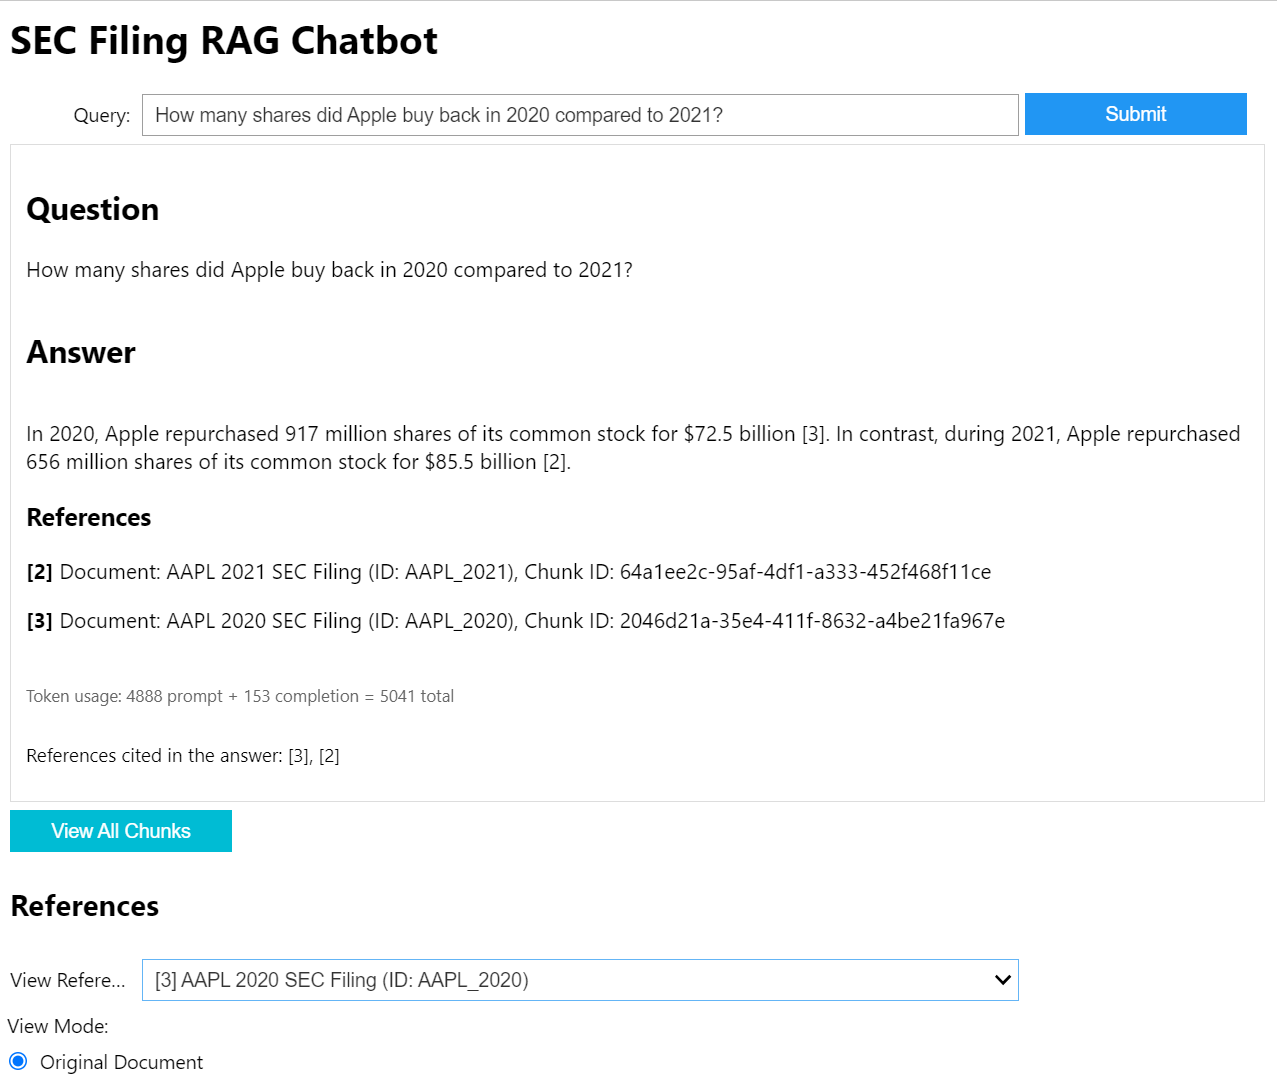

# Summary

Overall, the RAG system demonstrates strong performance in answering complex financial questions, with the identified improvements representing refinements to an already effective approach.